# <center> <span style="font-family: Virgil GS, sans-serif; color:navyblue">Benchmarking PD models</span> </center>

 <span style="font-family: Virgil GS, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

%matplotlib inline

In [3]:
import requests
import io

In [4]:
def timer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Execution time: {execution_time} seconds")
        return result
    return wrapper

In [2]:
csv_file = "https://raw.githubusercontent.com/deburky/boosting-scorecards/main/heloc_dataset_v1.csv"
data = pd.read_csv(csv_file)
data['RiskPerformance'].replace({'Good': 0, 'Bad': 1}, inplace=True)

### <span style="font-family: Virgil GS, sans-serif; color:navyblue">WOE Logistic Regression</span>

In [8]:
from sklearn.model_selection import train_test_split
from optbinning import BinningProcess, OptimalBinning
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

(CVXPY) Sep 02 02:43:16 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Sep 02 02:43:16 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [9]:
# Source: http://gnpalencia.org/optbinning/tutorials/tutorial_binning_process_FICO_update_binning.html
binning_fit_params = {
    "ExternalRiskEstimate": {"monotonic_trend": "descending"},
    "MSinceOldestTradeOpen": {"monotonic_trend": "descending"},
    "MSinceMostRecentTradeOpen": {"monotonic_trend": "descending"},
    "AverageMInFile": {"monotonic_trend": "descending"},
    "NumSatisfactoryTrades": {"monotonic_trend": "descending"},
    "NumTrades60Ever2DerogPubRec": {"monotonic_trend": "ascending"},
    "NumTrades90Ever2DerogPubRec": {"monotonic_trend": "ascending"},
    "PercentTradesNeverDelq": {"monotonic_trend": "descending"},
    "MSinceMostRecentDelq": {"monotonic_trend": "descending"},
    "NumTradesOpeninLast12M": {"monotonic_trend": "ascending"},
    "MSinceMostRecentInqexcl7days": {"monotonic_trend": "descending"},
    "NumInqLast6M": {"monotonic_trend": "ascending"},
    "NumInqLast6Mexcl7days": {"monotonic_trend": "ascending"},
    "NetFractionRevolvingBurden": {"monotonic_trend": "ascending"},
    "NetFractionInstallBurden": {"monotonic_trend": "ascending"},
    "NumBank2NatlTradesWHighUtilization": {"monotonic_trend": "ascending"},
}

special_codes = [-9, -8, -7]

In [10]:
variable_names = (pd.DataFrame(binning_fit_params).T).reset_index()["index"].to_list()

In [11]:
# features and target
X = data[variable_names + ["RiskPerformance"]].copy()
y = X.pop("RiskPerformance")

# sampling
ix_train, ix_test = train_test_split(
    X.index, stratify=y, test_size=0.3, shuffle=True, random_state=24
)

print(f"Train: {len(ix_train):,.0f}\nTest: {len(ix_test):,.0f}")

Train: 7,321
Test: 3,138


In [12]:
# instantiate a binning process class
binning_process = BinningProcess(
    variable_names, special_codes=special_codes, binning_fit_params=binning_fit_params
)

# mirroring statsmodels logistic regression
lr_params = {
    "fit_intercept": True,
    "penalty": None,
    "random_state": 72,
    "solver": "newton-cg",
}

# building a pipeline
lr_model = Pipeline(
    steps=[
        ("binning_process", binning_process),
        ("regressor", LogisticRegression(**lr_params)),
    ]
)

In [13]:
lr_model.fit(X.loc[ix_train], y.loc[ix_train])
y_pred_woe = lr_model.predict_proba(X.loc[ix_test])[:, 1]
gini_score_lr = roc_auc_score(y.loc[ix_test], y_pred_woe) * 2 - 1
print(f"Gini score: {gini_score_lr:.2%}")

Gini score: 58.89%


/opt/homebrew/lib/python3.11/site-packages/optbinning/binning/transformations.py:38: RuntimeWarning: invalid value encountered in log
  return np.log((1. / event_rate - 1) * n_event / n_nonevent)
/opt/homebrew/lib/python3.11/site-packages/optbinning/binning/transformations.py:38: RuntimeWarning: invalid value encountered in log
  return np.log((1. / event_rate - 1) * n_event / n_nonevent)


### <span style="font-family: Virgil GS, sans-serif; color:navyblue">XGBoost</span>

In [14]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [15]:
# scorer
val_metrics = ["auc", "logloss"]
base_score = y.loc[ix_train].mean().item()

# train and validation sets
eval_set = [(X.loc[ix_train], y.loc[ix_train]), (X.loc[ix_test], y.loc[ix_test])]

params = {
    "base_score": base_score,
    "learning_rate": 0.2,
    "n_estimators": 100,
    "max_depth": 2,
    "eval_metric": val_metrics,
    "early_stopping_rounds": 5,
    "tree_method": "hist",
    "random_state": 24,
}

start_time = time.time()
xgb_model = XGBClassifier(**params)

xgb_model.fit(X.loc[ix_train], y.loc[ix_train], eval_set=eval_set, verbose=False)

execution_time = time.time() - start_time
print(f"Training time: {execution_time:.4f} seconds")

y_pred_xgb = xgb_model.predict_proba(X.loc[ix_test])[:, 1]
gini_score_xgb = roc_auc_score(y.loc[ix_test], y_pred_xgb) * 2 - 1
print(f"Gini score: {gini_score_xgb:.2%}")

bstr = xgb_model.get_booster()
print(f"Best iteration: {bstr.best_iteration}")

Training time: 0.1554 seconds
Gini score: 58.87%
Best iteration: 49


### <span style="font-family: Virgil GS, sans-serif; color:navyblue">Visualize scoring power</span>

In [16]:
from sklearn.metrics import RocCurveDisplay

/opt/homebrew/lib/python3.11/site-packages/optbinning/binning/transformations.py:38: RuntimeWarning: invalid value encountered in log
  return np.log((1. / event_rate - 1) * n_event / n_nonevent)
/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_3670/2554389815.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_roc_auc_curve.set_xticklabels(
/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_3670/2554389815.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_roc_auc_curve.set_yticklabels(


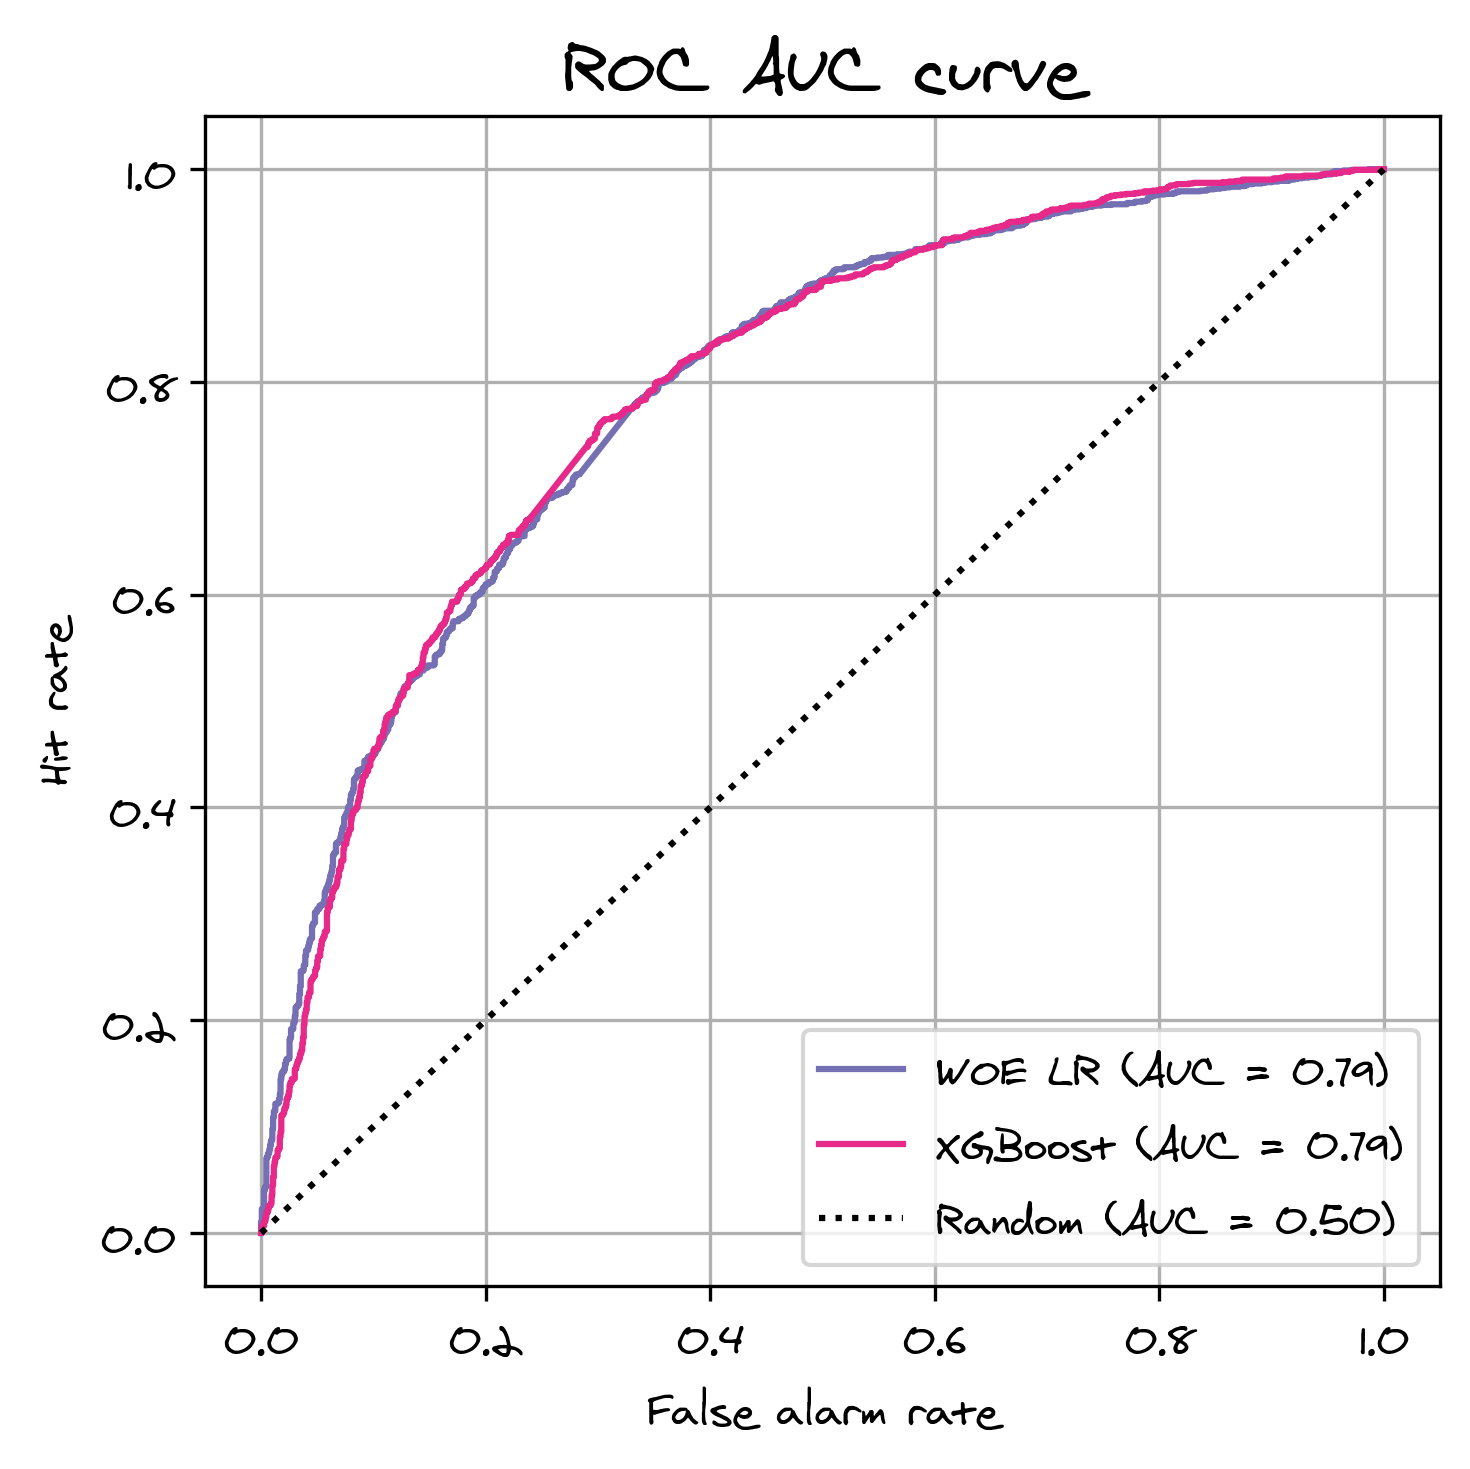

In [17]:
clf_list = [(lr_model, "WOE LR"), (xgb_model, "XGBoost")]

# Load the custom font file
custom_font = FontProperties(fname="Fonts/Virgil-GS-Regular.ttf")

plt.figure(figsize=(5, 5), dpi=300)
ax_roc_auc_curve = plt.axes()
colors = plt.colormaps.get_cmap("Dark2")

roc_auc_displays = {}

for i, (clf, name) in enumerate(clf_list):
    y_pred = clf.predict_proba(X.loc[ix_test])[:, 1]
    roc_auc_display = RocCurveDisplay.from_predictions(
        y.loc[ix_test], y_pred, ax=ax_roc_auc_curve, name=name, color=colors(i + 2)
    )
    roc_auc_displays[name] = roc_auc_display

ax_roc_auc_curve.grid()
ax_roc_auc_curve.plot([0, 1], [0, 1], "k:", label="Random (AUC = 0.50)")
# Set custom font for title and labels
ax_roc_auc_curve.set_title("ROC AUC curve", fontproperties=custom_font, fontsize=16)
ax_roc_auc_curve.set_xlabel("False alarm rate", fontproperties=custom_font)
ax_roc_auc_curve.set_ylabel("Hit rate", fontproperties=custom_font)

ax_roc_auc_curve.set_xticklabels(
    ax_roc_auc_curve.get_xticks(), fontproperties=custom_font
)
ax_roc_auc_curve.set_yticklabels(
    ax_roc_auc_curve.get_yticks(), fontproperties=custom_font
)

# Set custom font for x and y tick labels
ax_roc_auc_curve.xaxis.set_major_locator(MultipleLocator(0.2))
ax_roc_auc_curve.yaxis.set_major_locator(MultipleLocator(0.2))
ax_roc_auc_curve.xaxis.set_major_formatter(FormatStrFormatter("%0.1f"))
ax_roc_auc_curve.yaxis.set_major_formatter(FormatStrFormatter("%0.1f"))

# Customize legend
legend = ax_roc_auc_curve.legend(prop=custom_font)
for text in legend.get_texts():
    text.set_fontproperties(custom_font)

plt.tight_layout()
plt.savefig("roc_auc_curves.png", dpi=600)
plt.show()

### <span style="font-family: Virgil GS, sans-serif; color:navyblue">Loss benchmarking</span>

<span style="font-family: Virgil GS, sans-serif; color:navyblue">We can use a baseline log loss of a linear model to benchmark our challenger model against it. \
First, we introduce log loss and benchmark it against scoring functions.</span>

In [47]:
# Example
example_data = pd.DataFrame(
    {
    'Default': [0, 1, 0, 1, 1],
    'PD': [0.99, 0.99, 0.01, 0.67, 0.01]
})

example_data["log_loss"] = -(
    example_data["Default"] * np.log(example_data["PD"])
    + (1 - example_data["Default"]) * np.log(1 - example_data["PD"])
)

display(example_data[example_data.index.isin([0, 4])])
display(example_data[example_data.index.isin([1, 2])])


,Default,PD,log_loss
0,0,0.99,4.60517
4,1,0.01,4.60517


,Default,PD,log_loss
1,1,0.99,0.01005
2,0,0.01,0.01005


In [35]:
test_frame = pd.concat([X.loc[ix_test], y.loc[ix_test]], axis=1)
test_frame["woe"] = lr_model.predict_proba(X.loc[ix_test])[:, 1]
test_frame["xgb"] = xgb_model.predict_proba(X.loc[ix_test])[:, 1]

/opt/homebrew/lib/python3.11/site-packages/optbinning/binning/transformations.py:38: RuntimeWarning: invalid value encountered in log
  return np.log((1. / event_rate - 1) * n_event / n_nonevent)


In [36]:
test_frame["woe_loss"] = -(
    test_frame["RiskPerformance"] * np.log(test_frame["woe"])
    + (1 - test_frame["RiskPerformance"]) * np.log(1 - test_frame["woe"])
)

test_frame["xgb_loss"] = -(
    test_frame["RiskPerformance"] * np.log(test_frame["xgb"])
    + (1 - test_frame["RiskPerformance"]) * np.log(1 - test_frame["xgb"])
)

random_pred = 0.50
test_frame["random_loss"] = -(
    test_frame["RiskPerformance"] * np.log(random_pred)
    + (1 - test_frame["RiskPerformance"]) * np.log(1 - random_pred)
)

perfect_probability = 0.999
test_frame["ideal_loss"] = test_frame["RiskPerformance"].apply(
    lambda y_true: -(
        y_true * np.log(perfect_probability)
        + (1 - y_true) * np.log(1 - perfect_probability)
    )
    if y_true == 1
    else -(
        y_true * np.log(1 - perfect_probability)
        + (1 - y_true) * np.log(perfect_probability)
    )
)

In [37]:
cols_to_select = [
    "RiskPerformance",
    "woe",
    "xgb",
    "woe_loss",
    "xgb_loss",
    "random_loss",
    "ideal_loss",
]
test_frame = test_frame[cols_to_select].copy()

In [38]:
test_frame[0:2]

,RiskPerformance,woe,xgb,woe_loss,xgb_loss,random_loss,ideal_loss
7194,0,0.796720,0.858084,1.593173,1.952520,0.693147,0.001001
2384,1,0.896935,0.809336,0.108772,0.211541,0.693147,0.001001


### <span style="font-family: Virgil GS, sans-serif; color:navyblue">Visualize loss</span>
<span style="font-family: Virgil GS, sans-serif; color:navyblue">Plot loss for each class (good, bad).</span>

In [22]:
# Load the custom font file
custom_font = FontProperties(fname="Fonts/Virgil-GS-Regular.ttf")
colors = plt.colormaps.get_cmap("Dark2")

def plot_loss_curve(
    ax,
    data_frame,
    classifier_column,
    loss_column,
    color,
    label,
    class_label=1,
    delta=0.01,
    **kwargs
):
    sorted_frame = data_frame.sort_values(by=classifier_column)
    loss_1 = sorted_frame["RiskPerformance"] == class_label

    bins = list(np.arange(0, 1, delta)) + [1]
    classifier_values = sorted_frame[loss_1][classifier_column]
    loss_values = sorted_frame[loss_1][loss_column]

    avg_loss_values = []
    for bin_start, bin_end in zip(bins[:-1], bins[1:]):
        mask = (classifier_values >= bin_start) & (classifier_values < bin_end)
        avg_loss = np.mean(loss_values[mask])
        avg_loss_values.append(avg_loss)

    ax.plot(
        bins[:-1],
        avg_loss_values,
        linestyle="-",
        color=color,
        label=label,
        alpha=0.9,
        **kwargs
    )

/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_3670/2808280333.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ax1.get_yticks(), fontproperties=custom_font)
/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_3670/2808280333.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2.get_yticks(), fontproperties=custom_font)


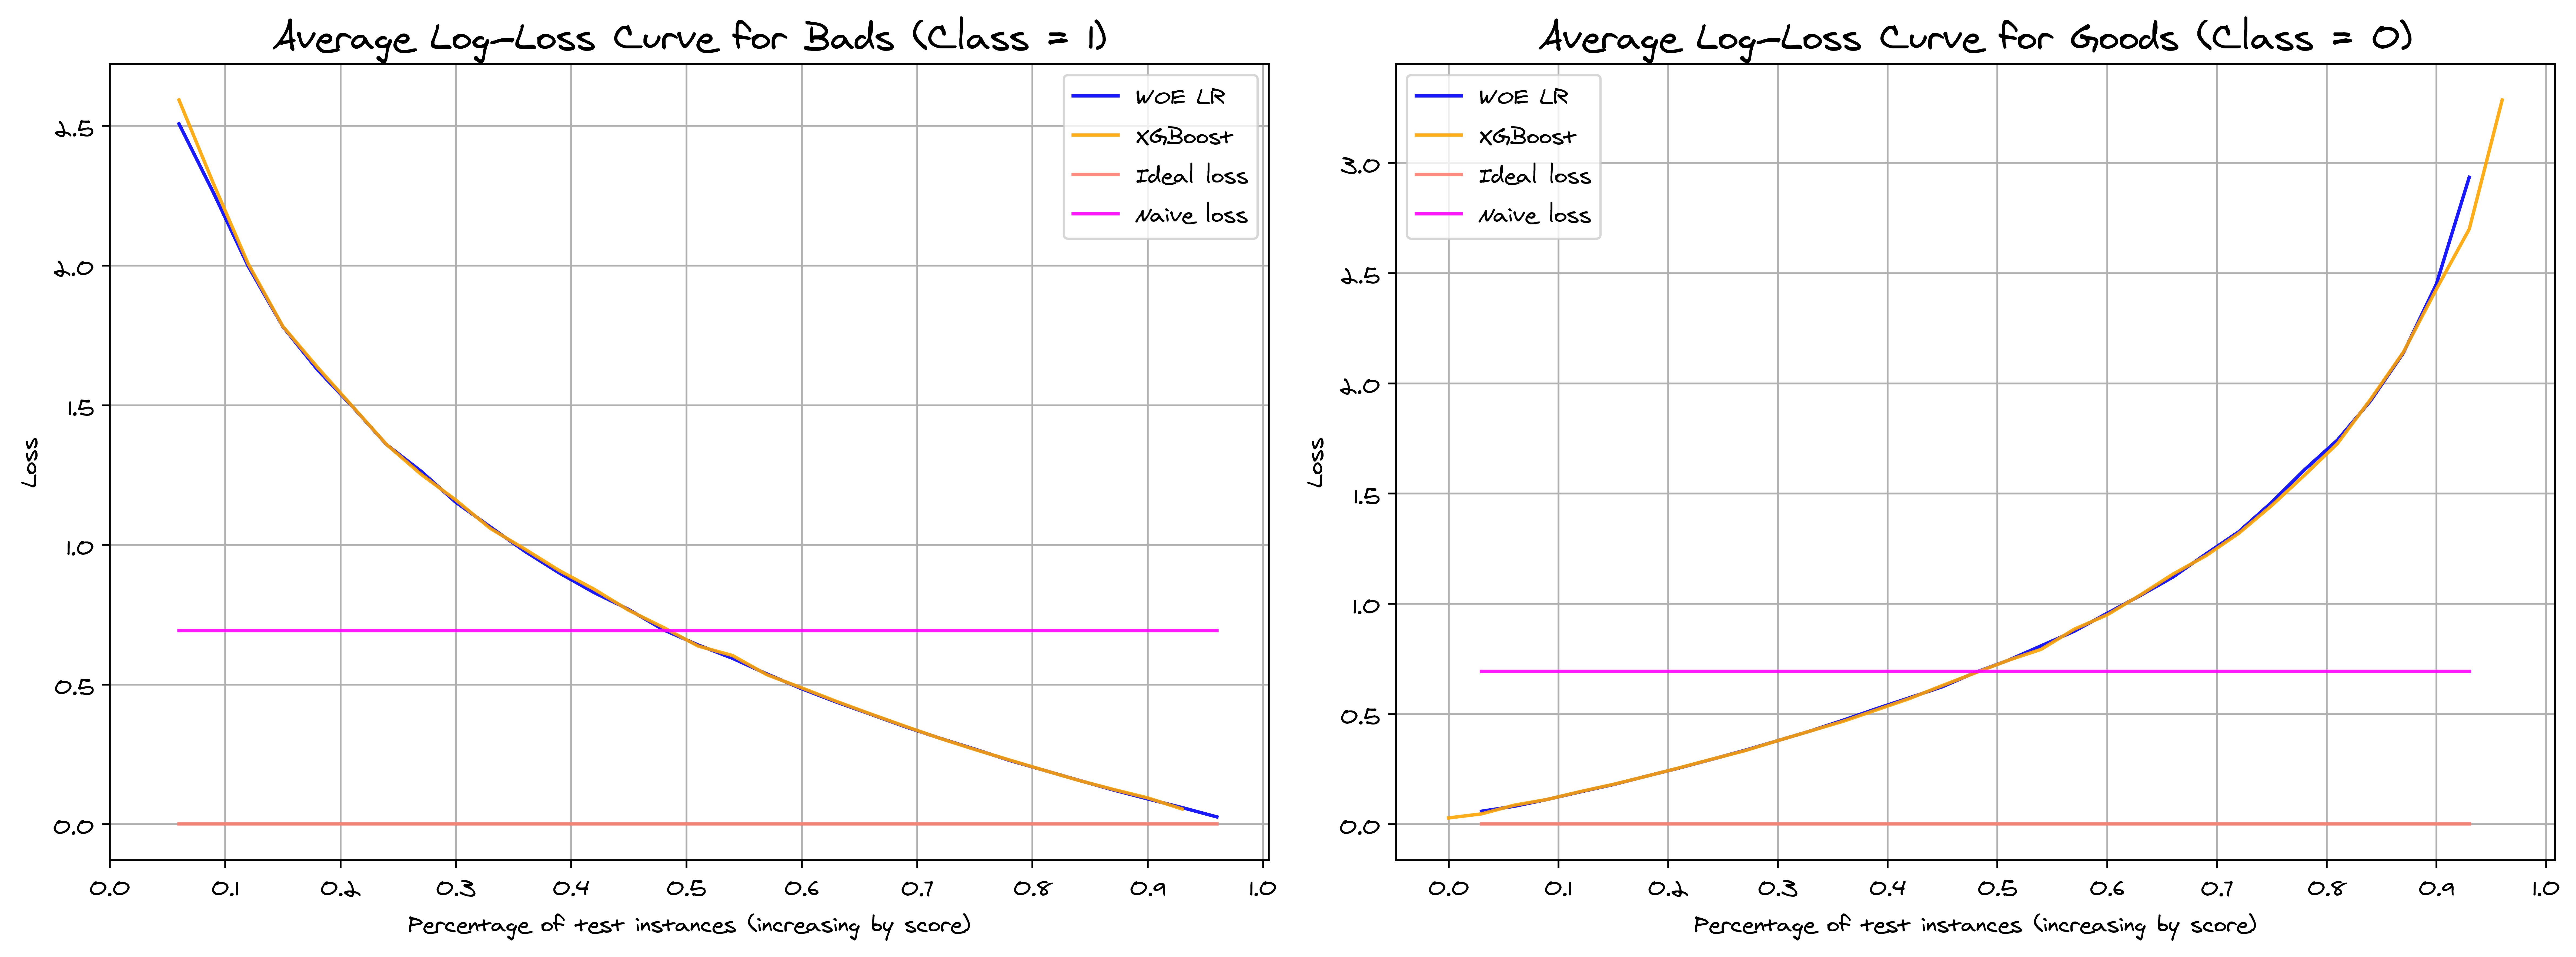

In [23]:

# Define your classifier-loss column pairs
classifier_loss_pairs = [
    ("woe", "woe_loss", "blue", "WOE LR"),
    ("xgb", "xgb_loss", "orange", "XGBoost"),
    ("woe", "ideal_loss", "salmon", "Ideal loss"),
    ("woe", "random_loss", "fuchsia", "Naive loss"),
]

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=600)

# First subplot: bad = 1
ax1 = axes[0]
for classifier_column, loss_column, color, label in classifier_loss_pairs:
    plot_loss_curve(
        ax1,
        test_frame,
        classifier_column,
        loss_column,
        color,
        label,
        class_label=1,
        delta=0.03,
    )
ax1.set_xlabel(
    "Percentage of test instances (increasing by score)", fontproperties=custom_font
)
ax1.set_ylabel("Loss", fontproperties=custom_font)
ax1.set_title(
    "Average Log-Loss Curve for Bads (Class = 1)",
    fontproperties=custom_font,
    fontsize=16,
)
ax1.grid(True)
ax1.legend(prop=custom_font)
ax1.set_xticks(np.arange(0, 1.1, 0.1))

ax1.set_xticklabels(
    ax1.get_xticks(), fontproperties=custom_font
)  # Set custom font for x tick labels
ax1.set_yticklabels(ax1.get_yticks(), fontproperties=custom_font)

# Set custom font for x and y tick labels
ax1.xaxis.set_major_locator(MultipleLocator(0.1))
ax1.yaxis.set_major_locator(MultipleLocator(0.5))
ax1.xaxis.set_major_formatter(FormatStrFormatter("%0.1f"))
ax1.yaxis.set_major_formatter(FormatStrFormatter("%0.1f"))
# ax1.xaxis.set_tick_params(labelrotation=45)

# Second subplot: bad = 0
ax2 = axes[1]
for classifier_column, loss_column, color, label in classifier_loss_pairs:
    plot_loss_curve(
        ax2,
        test_frame,
        classifier_column,
        loss_column,
        color,
        label,
        class_label=0,
        delta=0.03,
    )
ax2.set_xlabel(
    "Percentage of test instances (increasing by score)", fontproperties=custom_font
)
ax2.set_ylabel("Loss", fontproperties=custom_font)
ax2.set_title(
    "Average Log-Loss Curve for Goods (Class = 0)",
    fontproperties=custom_font,
    fontsize=16,
)
ax2.grid(True)
ax2.legend(prop=custom_font)
ax2.set_xticks(np.arange(0, 1.1, 0.1))

ax2.set_xticklabels(ax2.get_xticks(), fontproperties=custom_font)
ax2.set_yticklabels(ax2.get_yticks(), fontproperties=custom_font)

# Set custom font for x and y tick labels
ax2.xaxis.set_major_locator(MultipleLocator(0.1))
ax2.yaxis.set_major_locator(MultipleLocator(0.5))
ax2.xaxis.set_major_formatter(FormatStrFormatter("%0.1f"))
ax2.yaxis.set_major_formatter(FormatStrFormatter("%0.1f"))

plt.tight_layout()
plt.savefig("loss_curves.png", dpi=600)
plt.show()

### <span style="font-family: Virgil GS, sans-serif; color:navyblue">Loss uplift</span>
<span style="font-family: Virgil GS, sans-serif; color:navyblue">Our intuition is that we use a baseline loss (denominator) for each prediction and calculate an uplift based on a challenger model (nominator). Hence, the loss metric is an average of uplifts (<code>challenger_loss / baseline_loss</code>) per prediction.</span>

In [24]:
from sklearn.metrics import log_loss

In [138]:
def loss_uplift(
    y_true: np.ndarray, y_pred: np.ndarray, y_base: np.ndarray
    ):
    """Calculate the relative log loss:

    RLL = (1/N)∑(-(y_i * log(p_c_i) + (1 - y_i) * log(1 - p_c_i)))
        - (-(y_i * log(p_b_i) + (1 - y_i) * log(1 - p_b_i)))

    Adapted from source:
    He, X., Pan, J., Jin, O., Xu, T., Liu, B., Xu, T.,
    Shi, Y., Atallah, A., Herbrich, R., Bowers, S., Candela, J. Q.
    (2014). Practical Lessons from Predicting Clicks on Ads at
    Facebook. Proceedings of the Eighth International Workshop on
    Data Mining for Online Advertising 1-9.
    https://doi.org/10.1145/2648584.2648589

    Parameters:
        preds (array-like): Numeric vector of risk estimates.
        y (array-like): Vector of true binary outcomes (0 or 1).

    Returns:
        pd.DataFrame: a DataFrame with loss metrics
        np.ndarray: relative loss score
    """
    eps = 1e-15  # Small value to avoid log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)

    ce = -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    baseline = -(y_true * np.log(y_base) + (1 - y_true) * np.log(1 - y_base))

    ce_to_baseline = ce - baseline
    loss_uplift = np.mean(ce_to_baseline)

    df = pd.DataFrame(
        {
            "y_true": y_true,
            "y_pred": y_pred,
            "y_baseline": y_base,
            "ce": ce,
            "baseline": baseline,
            "ce_to_baseline": ce_to_baseline,
        }
    )

    return df, loss_uplift

#### <span style="font-family: Virgil GS, sans-serif; color:navyblue">Loss uplift testing</span>
<span style="font-family: Virgil GS, sans-serif; color:navyblue">We benchmark WOE LR to an XGBoost model to see which scoring functions gives a better business metric.</span>

In [139]:
# create a dataframe with labels, predictions, and baselines
labels_preds = pd.DataFrame(
    np.column_stack(
        (
            y.loc[ix_test],
            y_pred_woe,  # challenger
            y_pred_xgb,  # baseline
        )
    ),
    columns=["label", "prediction", "baseline"],
)

In [140]:
# Bads loss uplift
cond_class = labels_preds["label"] == 1

df_testing = loss_uplift(
    labels_preds[cond_class].iloc[:, 0],
    labels_preds[cond_class].iloc[:, 1],
    labels_preds[cond_class].iloc[:, 2],
)[0]

# print(df_testing.sort_values(by='y_pred', ascending=False)[0:5])
loss_uplift_metric = round(df_testing["ce_to_baseline"].mean(), 4)
print(f"Uplift bads: {loss_uplift_metric:.2%}")

# Goods loss uplift
df_testing = loss_uplift(
    labels_preds[~cond_class].iloc[:, 0],
    labels_preds[~cond_class].iloc[:, 1],
    labels_preds[~cond_class].iloc[:, 2],
)[0]

# print(df_testing.sort_values(by='y_pred', ascending=False)[0:5])
loss_uplift_metric = round(df_testing["ce_to_baseline"].mean(), 4)
print(f"Uplift goods: {loss_uplift_metric:.2%}")

# Overall loss uplift
df_testing = loss_uplift(
    labels_preds.iloc[:, 0], labels_preds.iloc[:, 1], labels_preds.iloc[:, 2]
)[0]

# print(df_testing.sort_values(by='y_pred', ascending=False)[0:5])
loss_uplift_metric = round(df_testing["ce_to_baseline"].mean(), 4)
print(f"Uplift: {loss_uplift_metric:.2%}")

Uplift bads: -0.02%
Uplift goods: -0.20%
Uplift: -0.10%


### <span style="font-family: Virgil GS, sans-serif; color:navyblue">Business metric</span>
<span style="font-family: Virgil GS, sans-serif; color:navyblue">Although we observe a reduction in loss compared to the baseline, the loss metric is not sensitive the numbers of observations for each bin as an arithmetic average. \
We want to account for it by quantifying loss in monetary terms using a cost-benefit matrix.</span>

In [141]:
# Define the cost matrix
cost_matrix = {
    "TP": 0,  # True Positive
    "TN": 0,  # True Negative
    "FP": 50,  # False Positive
    "FN": 100,  # False Negative
}


def calculate_payout(row):
    # if our predictions for class 0 is worse than baseline it's -20, else +20
    if row["y_true"] == 0:
        if row["y_pred"] < row["y_baseline"]:
            return cost_matrix["FP"]
        else:
            return -cost_matrix["FP"]
    # if our predictions for class 1 is worse than baseline it's -100, else +100
    elif row["y_true"] == 1:
        if row["y_pred"] > row["y_baseline"]:
            return cost_matrix["FN"]
        else:
            return -cost_matrix["FN"]


def plot_payout_curve(
    ax,
    data_frame,
    classifier_column,
    payout_column,
    color,
    label,
    class_label=1,
    delta=0.05,
    **kwargs
):
    sorted_frame = data_frame.sort_values(by=classifier_column)
    payout_class = sorted_frame["y_true"] == class_label

    bins = list(np.arange(0, 1, delta)) + [1]
    classifier_values = sorted_frame[payout_class][classifier_column]
    payout_values = sorted_frame[payout_class][payout_column]

    avg_payout_values = []
    for bin_start, bin_end in zip(bins[:-1], bins[1:]):
        mask = (classifier_values >= bin_start) & (classifier_values < bin_end)
        avg_payout = np.mean(payout_values[mask])
        avg_payout_values.append(avg_payout)

    ax.fill_between(
        bins[:-1], 0, avg_payout_values, color=color, label=label, alpha=0.4, **kwargs
    )


# calculate the number of users per bin
def calculate_num_users(bin_start, bin_end):
    return len(
        df_testing[
            (df_testing["y_pred"] >= bin_start) & (df_testing["y_pred"] < bin_end)
        ]
    )


df_testing["payout"] = df_testing.apply(calculate_payout, axis=1)

/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_3670/4043160070.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), fontproperties=custom_font)
/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_3670/4043160070.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ax1.get_yticks(), fontproperties=custom_font)
/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_3670/4043160070.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), fontproperties=custom_font)
/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_3670/4043160070.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2.get_yticks(), fontproperties=custom_font)


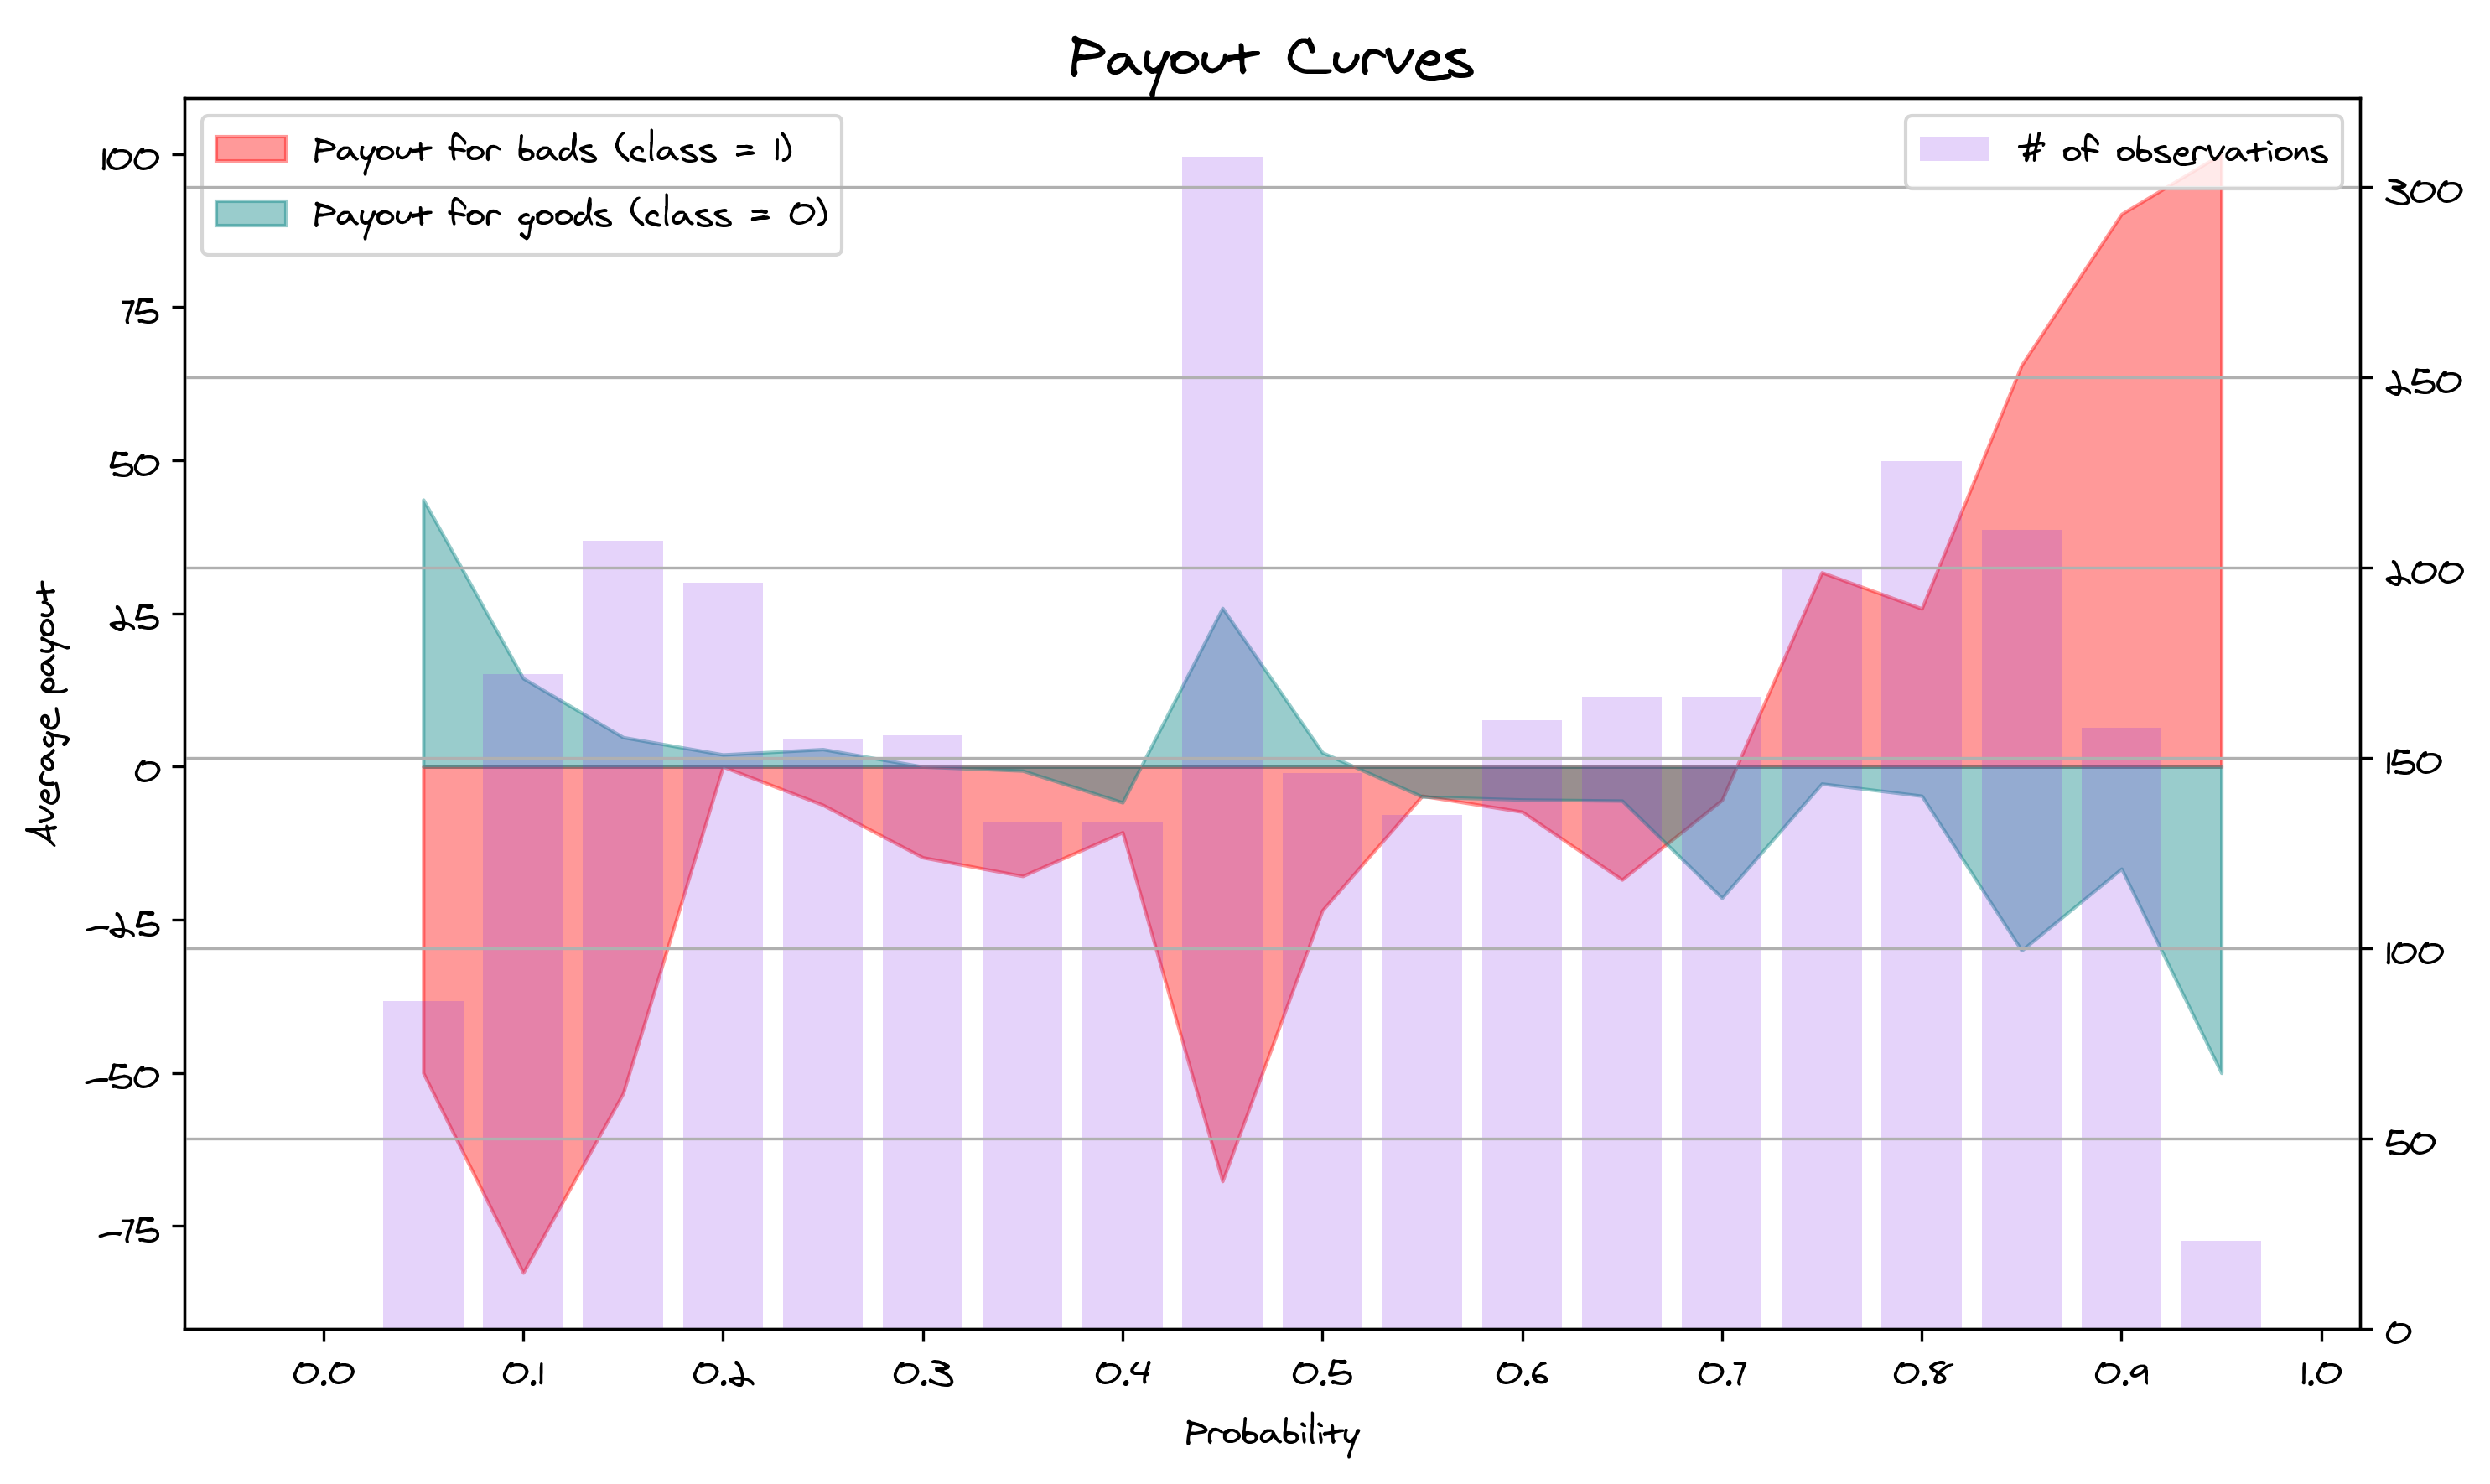

In [142]:
plt.figure(figsize=(10, 6), dpi=300)
ax1 = plt.gca()

plot_payout_curve(
    ax1,
    df_testing,
    "y_pred",
    "payout",
    color="red",
    label="Payout for bads (class = 1)",
    class_label=1,
)
plot_payout_curve(
    ax1,
    df_testing,
    "y_pred",
    "payout",
    color="teal",
    label="Payout for goods (class = 0)",
    class_label=0,
)

# create a primary y-axis for the payouts
ax1.set_xlabel("Probability", fontproperties=custom_font)
ax1.set_ylabel("Average payout", fontproperties=custom_font)
ax1.set_title("Payout Curves", fontproperties=custom_font, fontsize=16)
ax1.legend(loc="upper left", prop=custom_font)
ax1.set_xticklabels(ax1.get_xticks(), fontproperties=custom_font)
ax1.set_yticklabels(ax1.get_yticks(), fontproperties=custom_font)
ax1.xaxis.set_major_locator(MultipleLocator(0.1))
ax1.xaxis.set_major_formatter(FormatStrFormatter("%0.1f"))
ax1.yaxis.set_major_formatter(FormatStrFormatter("%0.0f"))

# calculate the number of users for each bin
bins = list(np.arange(0, 1, 0.05)) + [1]
num_users = [
    calculate_num_users(bin_start, bin_end)
    for bin_start, bin_end in zip(bins[:-1], bins[1:])
]

# create a secondary y-axis for the bar chart
ax2 = ax1.twinx()
ax2.bar(
    bins[:-1],
    num_users,
    width=0.04,
    alpha=0.2,
    color="#8027ea20",
    label="# of observations",
)
# ax2.set_ylabel('Number of users', fontproperties=custom_font)
ax2.legend(loc="upper right", prop=custom_font)
ax2.set_xticklabels(ax2.get_xticks(), fontproperties=custom_font)
ax2.set_yticklabels(ax2.get_yticks(), fontproperties=custom_font)
ax2.xaxis.set_major_locator(MultipleLocator(0.1))
ax2.xaxis.set_major_formatter(FormatStrFormatter("%0.1f"))
ax2.yaxis.set_major_formatter(FormatStrFormatter("%0.0f"))

plt.tight_layout()
plt.grid(True)
plt.savefig("payout.png", dpi=600)
plt.show()

In [143]:
payout = df_testing["payout"].sum()
print(f"Payout: €{payout:,.0f}")

Payout: €20,300


### <span style="font-family: Virgil GS, sans-serif; color:navyblue">Additional plots</span>

In [144]:
def add_probability_bins(data_frame, delta=0.05):
    bins = list(np.arange(0, 1, delta)) + [1]
    data_frame['p'] = pd.cut(
        data_frame['y_pred'], 
        bins, 
        labels=bins[:-1])
    return data_frame

df_testing_binned = add_probability_bins(
    df_testing, delta=0.05)

display(df_testing_binned[
    (df_testing_binned['y_true'] == 1)
    & (df_testing_binned['p'] < 0.2)
    ][['ce', 'baseline', 'payout']].mean())

display(df_testing_binned[
    (df_testing_binned['y_true'] == 0)
    & (df_testing_binned['p'] > 0.8)
    ][['ce', 'baseline', 'payout']].mean())

ce           1.949558
baseline     1.723076
payout     -63.934426
dtype: float64

ce           2.257111
baseline     2.055092
payout     -26.086957
dtype: float64

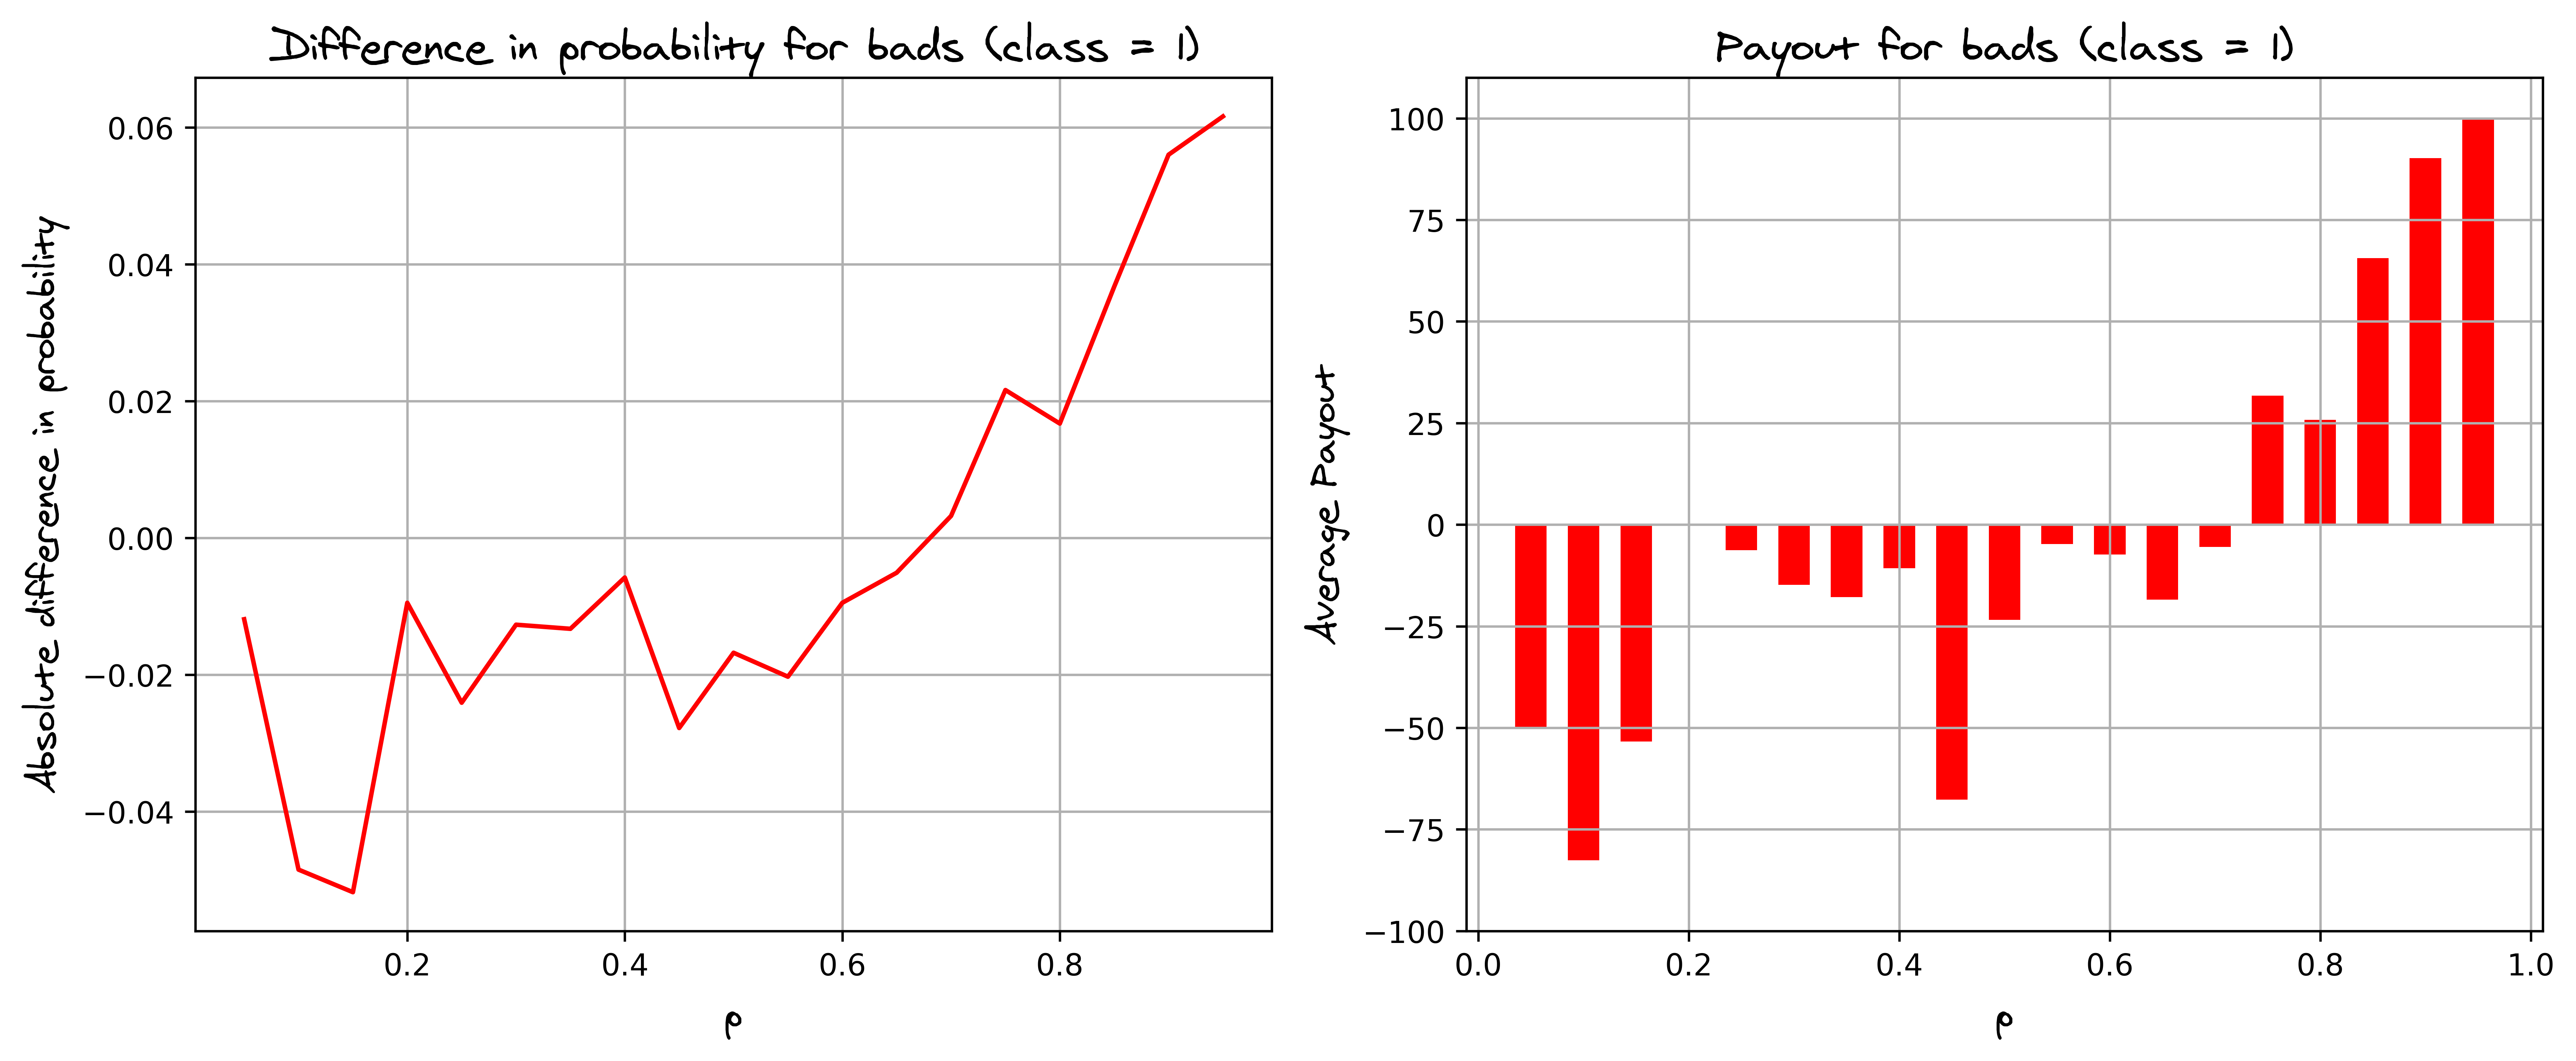

In [145]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=600)

# Subplot 1: Line chart
df_bads = df_testing_binned[df_testing_binned['y_true'] == 1][
    ['p', 'y_pred', 'y_baseline', 'payout']].groupby('p').agg(
        pred=('y_pred', 'mean'),
        base=('y_baseline', 'mean'),
    ).reset_index()

df_bads['pred'] = round(df_bads['pred'], 4)
df_bads['base'] = round(df_bads['base'], 4)
df_bads['abs_diff_in_proba'] = df_bads['pred'] - df_bads['base']

axs[0].plot(df_bads['p'], df_bads['abs_diff_in_proba'], color='red')
axs[0].set_title('Difference in probability for bads (class = 1)', fontproperties=custom_font, fontsize=14)
axs[0].set_xlabel('p', fontproperties=custom_font, fontsize=12)
axs[0].set_ylabel('Absolute difference in probability', fontproperties=custom_font, fontsize=12)
axs[0].grid()

# Subplot 2: Bar chart
df_pay = df_testing_binned[df_testing_binned['y_true'] == 1][
    ['p', 'y_pred', 'y_baseline', 'payout']].groupby('p').agg(
        pay=('payout', 'mean'),
    ).reset_index()

axs[1].bar(df_pay['p'], df_pay['pay'], width=0.03, color='red')
axs[1].set_title('Payout for bads (class = 1)', fontproperties=custom_font, fontsize=14)
axs[1].set_xlabel('p', fontproperties=custom_font, fontsize=12)
axs[1].set_ylabel('Average Payout', fontproperties=custom_font, fontsize=12)
axs[1].set_ylim(-100, 110)
axs[1].grid()

plt.tight_layout()
plt.show()

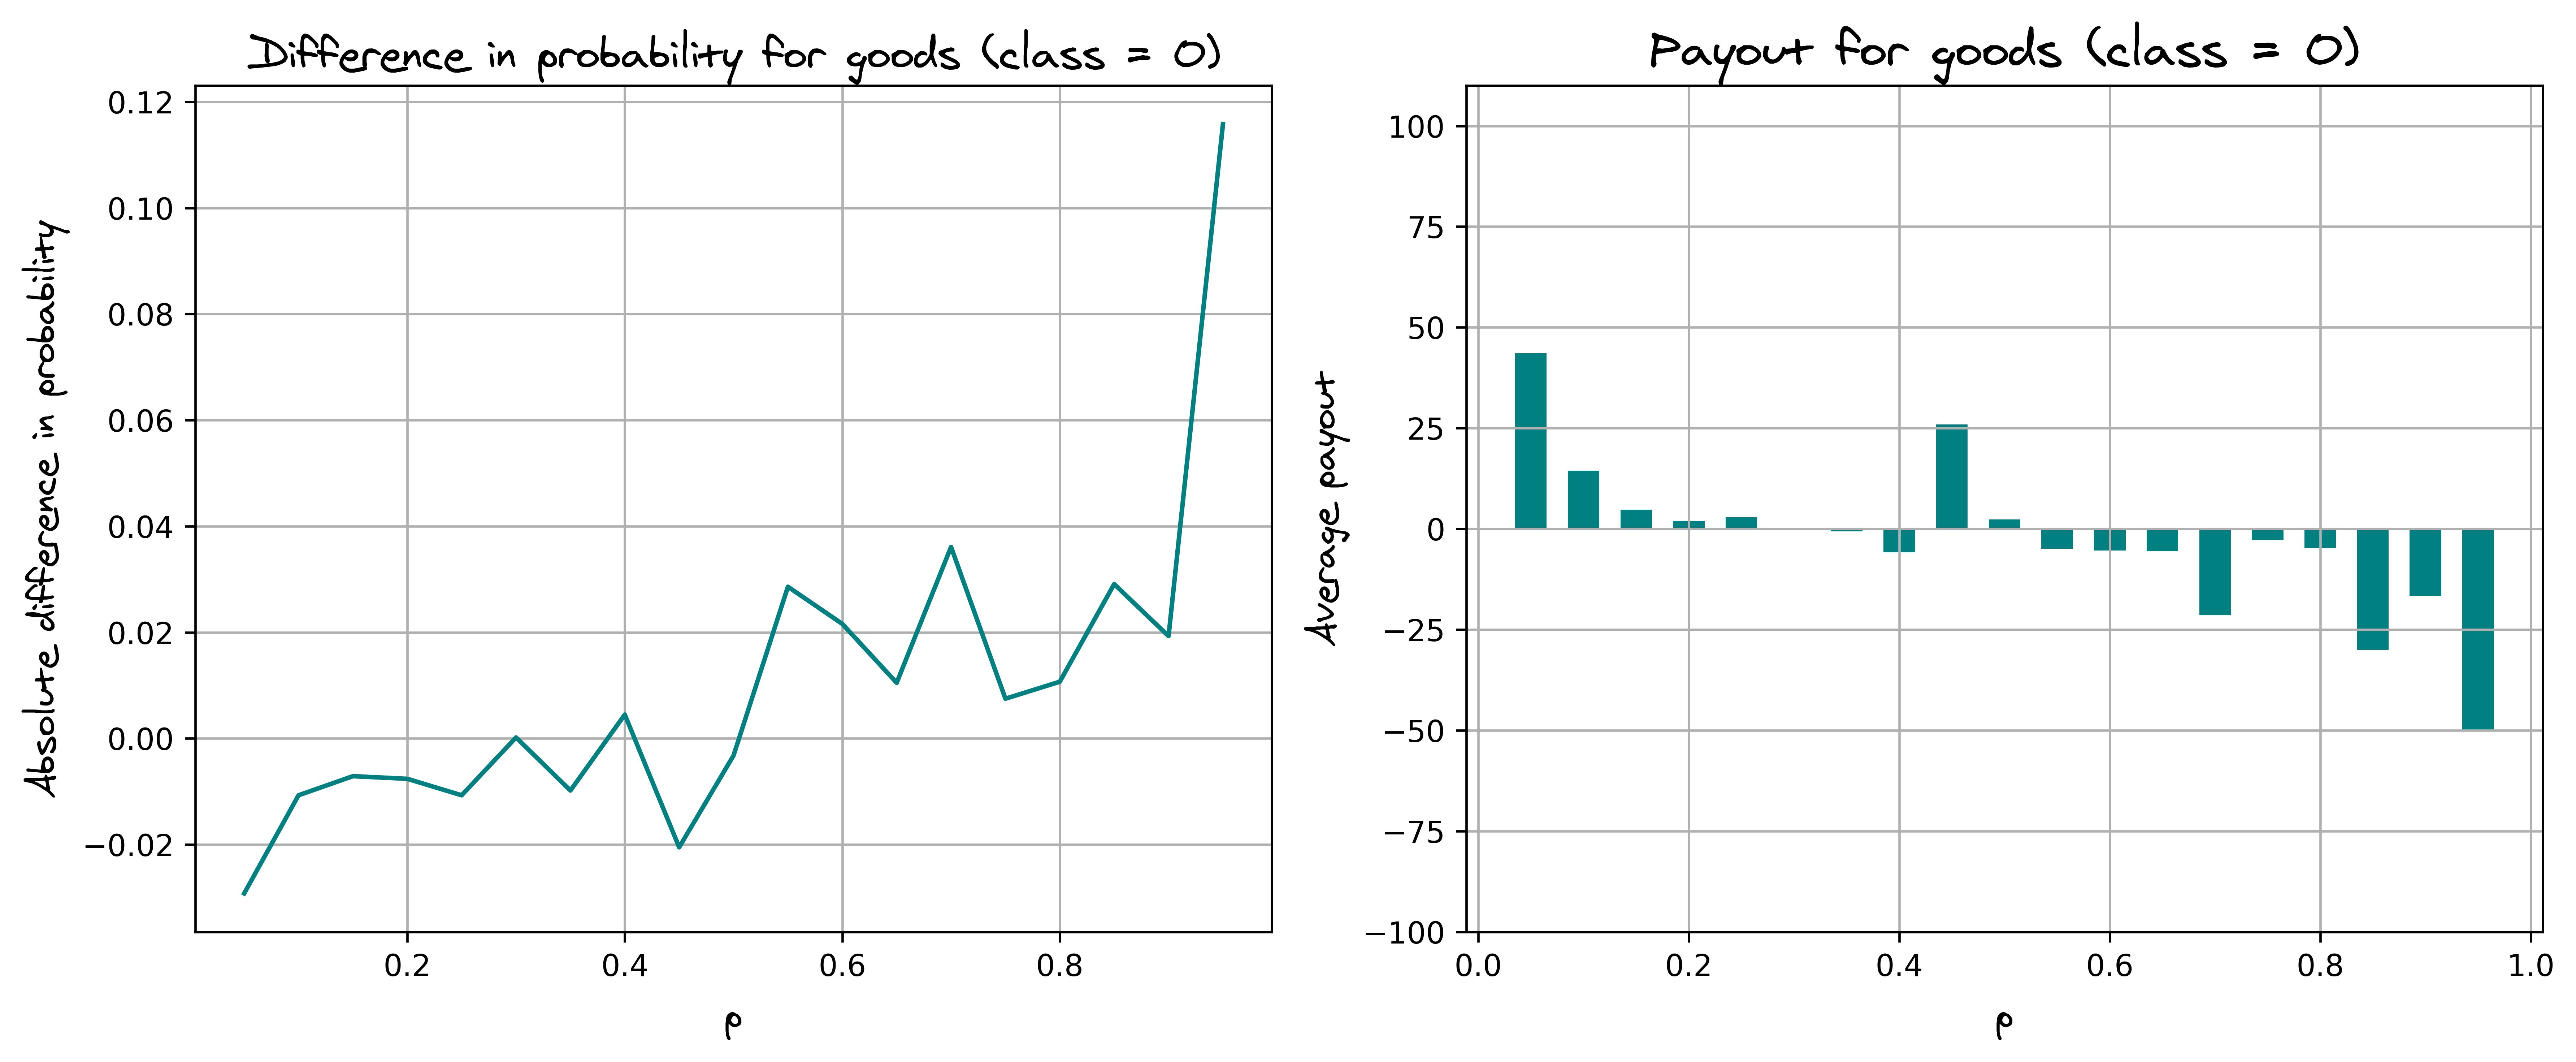

In [146]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=600)

# Subplot 1: Line chart
df_goods = df_testing_binned[df_testing_binned['y_true'] == 0][
    ['p', 'y_pred', 'y_baseline', 'payout']].groupby('p').agg(
        pred=('y_pred', 'mean'),
        base=('y_baseline', 'mean'),
    ).reset_index()

df_goods['pred'] = round(df_goods['pred'], 4)
df_goods['base'] = round(df_goods['base'], 4)
df_goods['abs_diff_in_proba'] = df_goods['pred'] - df_goods['base']

axs[0].plot(df_goods['p'], df_goods['abs_diff_in_proba'], color='teal')
axs[0].set_title('Difference in probability for goods (class = 0)', fontproperties=custom_font, fontsize=14)
axs[0].set_xlabel('p', fontproperties=custom_font, fontsize=12)
axs[0].set_ylabel('Absolute difference in probability', fontproperties=custom_font, fontsize=12)
axs[0].grid()

# Subplot 2: Bar chart
df_pay = df_testing_binned[df_testing_binned['y_true'] == 0][
    ['p', 'y_pred', 'y_baseline', 'payout']].groupby('p').agg(
        pay=('payout', 'mean'),
    ).reset_index()

axs[1].bar(df_pay['p'], df_pay['pay'], width=0.03, color='teal')
axs[1].set_title('Payout for goods (class = 0)', fontproperties=custom_font, fontsize=16)
axs[1].set_xlabel('p', fontproperties=custom_font, fontsize=12)
axs[1].set_ylabel('Average payout', fontproperties=custom_font, fontsize=12)
axs[1].set_ylim(-100, 110)
axs[1].grid()

plt.tight_layout()
plt.show()